In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import io
from mpl_toolkits.mplot3d import Axes3D

import config

In [2]:
def PlotSpectraAndMean(Spectra, Wv, fignum):
    x = Spectra.T.copy() ### Spectra as NBands x NSamps
    mu = np.mean(x, axis=1)
    plt.figure(fignum)
    plt.plot(Wv, x, 'c')
    plt.plot(Wv, mu, 'r')
    plt.xlabel('Wavelenght (nm)')
    plt.ylabel('Reflectance')
    plt.show()
    return mu

In [3]:
filename   = os.path.join(config.RSDI_DATASET_DIR, 'OSBSTinyIm.mat')
ImDict     = io.loadmat(filename)
OSBSTinyIm = ImDict['OSBSTinyIm']
TinySize   = np.shape(OSBSTinyIm)

NRows, NCols, NBands = OSBSTinyIm.shape
print('{0:4d} {1:4d} {2:4d}'.format(NRows, NCols, NBands))

  62  194  346


Now we can extract wavelengths.

(346, 1)


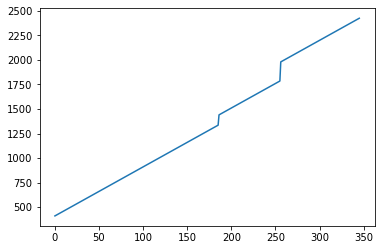

In [4]:
### LOAD WAVELENGTHS WITH WATER BANDS ###
### AND BAD BEGINNING AND ENDING BANDS REMOVED ###
Wv = io.loadmat(os.path.join(config.RSDI_DATASET_DIR,'NEONWvsNBB.mat'))
Wv = Wv['NEONWvsNBB']
print(np.shape(Wv))

plt.figure(1)
plt.plot(range(346), Wv)
plt.show()

Let's load indices for Red, Green, and Blue for NEON hyperspectral data.

In [5]:
### HAVE TO SUBTRACT AN OFFSET BECAUSE OF BAD BAND ###
### REMOVAL AND 0-BASED Python vs 1-Based MATLAB   ###
Offset     = 7

### LOAD & PRINT THE INDICES FOR THE COLORS   ###
### AND DIG THEM OUT OF MANY LAYERS OF ARRAYS ###
NEONColors = io.loadmat(os.path.join(config.RSDI_DATASET_DIR,'NEONColors.mat'))
NEONRed    = NEONColors['NEONRed'].item()
NEONGreen  = NEONColors['NEONGreen'].item()
NEONBlue   = NEONColors['NEONBlue'].item()
NEONNir    = NEONColors['NEONNir'].item()
NEONRed    = NEONRed-Offset
NEONGreen  = NEONGreen-Offset
NEONBlue   = NEONBlue-Offset
NEONNir    = NEONNir-Offset
print('Indices:     {0:4d} {1:4d} {2:4d} {3:4d}'.format(NEONRed, NEONGreen, NEONBlue, NEONNir))

### CONVERT THE INDICES TO WAVELENGTHS ###
NEONRedWv    = Wv[NEONRed].item()
NEONGreenWv  = Wv[NEONGreen].item()
NEONBlueWv   = Wv[NEONBlue].item()
NEONNirWv    = Wv[NEONNir].item()
print('Wavelengths: {0:4d} {1:4d} {2:4d} {3:4d}'.format(NEONRedWv, NEONGreenWv, NEONBlueWv, NEONNirWv))

Indices:       47   25    6  119
Wavelengths:  645  535  440 1005


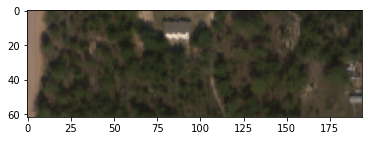

In [6]:
RGBIm = OSBSTinyIm[:, :, [NEONRed, NEONGreen, NEONBlue]]
RGBIm = np.sqrt(RGBIm)
plt.figure(2)
plt.imshow(RGBIm)
plt.show()

Now let's turn the image into a sequence of vectors so we can use matrix algebra

In [7]:
### HAVE TO TAKE INTO ACCOUNT DIFFERENCES BETWEEN Python AND Matlab ###
### Python USES THE    C     PROGRAMMING LANGUAGE ORDERING ###
### MATLAB USERS THE FORTRAN PROGRAMMING LANGUAGE ORDERING ###
### Python WOULD RESHAPE BY REFERENCE AND MATLAB BY VALUE  ###
### THEREFORE, WE NEED TO COPY THE VALUES EXPLICITLY       ###
# Torch flatten used C-like order, lo dejaré por ahora así pero lo cambiaré a posteriori.
TinyVecs = OSBSTinyIm.reshape(NRows*NCols, NBands, order='F').copy()
np.shape(TinyVecs)

(12028, 346)

# Covariance between bands

(346, 346)


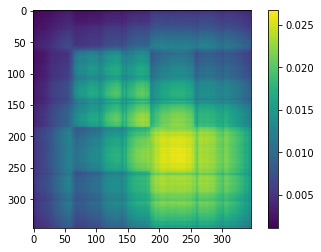

In [8]:
C = np.cov(TinyVecs.T)
print(np.shape(C))
plt.figure(6)
plt.imshow(C)
plt.colorbar()
plt.show()

In [9]:
import numpy as np
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin

class Norm1Transform(TransformerMixin, BaseEstimator):
    '''
        X is noramlized in order to have 1-Normed vector space, i.e, the samples
        are normalized in order the Norm ||X|| is 1.
    '''
    def __init__(self, n_features_to_select=None):
        super(Norm1Transform, self).__init__()

    def fit(self, X, y=None):
        '''
            Parameters
            ----------
            X : array, shape (n_samples, n_features)
                Data from which to compute the Norm which will be used in order to generate a 1-normed vector space.

            y : any, default=None
                Ignored. This parameter exists only for compatibility with
                sklearn.pipeline.Pipeline.

            Returns
            -------
            self : object
                Returns the instance itself.
        '''
        self.norms_ = np.sqrt(np.sum(X**2, axis=1))
        return self

    def transform(self, X, y=None, **kwargs):
        check_is_fitted(self)
        return X / self.norms_[:,np.newaxis]

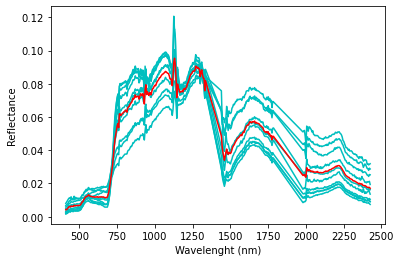

In [10]:
transform = Norm1Transform()
TinyVecsNorm = transform.fit_transform(TinyVecs.copy())

SpecIndices     = range(1000, 2000, 100)
SomeSpectraNorm = TinyVecsNorm[range(1000, 2000, 100), :]
MuNorm          = PlotSpectraAndMean(SomeSpectraNorm, Wv, 3)

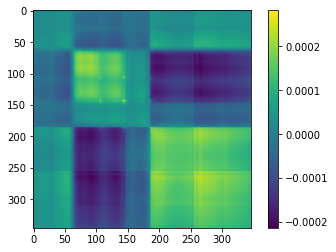

In [11]:
CNorm = np.cov(TinyVecsNorm.T)
plt.figure()
plt.imshow(CNorm)
plt.colorbar()
plt.show()

# PCA

In [212]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, svd_solver='auto', whiten=True)
test = pca.fit_transform(TinyVecsNorm.copy())

test = test.reshape((NRows, NCols, -1), order='F')

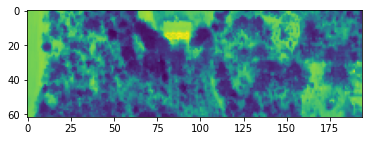

In [214]:
from matplotlib import pyplot as pyplot

plt.imshow(test[:,:,0])

In [177]:
pca.singular_values_

array([21.46410081,  6.34017742,  3.63344774])

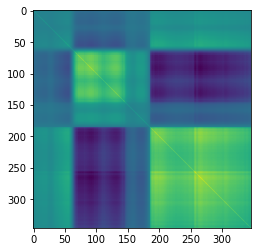

In [179]:
plt.imshow(pca.get_covariance())

# TruncatedSVD

In [159]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=4, algorithm='randomized')
test = svd.fit_transform(TinyVecsNorm.copy())

test = test.reshape((NRows, NCols, -1), order='F')

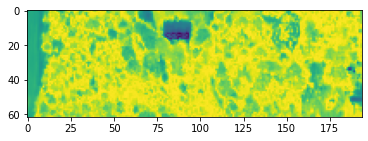

In [161]:
from matplotlib import pyplot as pyplot

plt.imshow(test[:,:,0])

# Sparse PCA

In [180]:
from sklearn.decomposition import SparsePCA

pca = SparsePCA(n_components=4)
test = pca.fit_transform(TinyVecsNorm.copy())

test = test.reshape((NRows, NCols, -1), order='F')

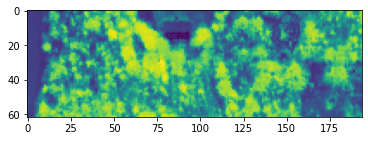

In [181]:
from matplotlib import pyplot as pyplot

plt.imshow(test[:,:,0])

# IncrementalPCA

In [200]:
from sklearn.decomposition import IncrementalPCA

pca = IncrementalPCA(n_components=4)
test = pca.fit_transform(TinyVecsNorm.copy())

test = test.reshape((NRows, NCols, -1), order='F')

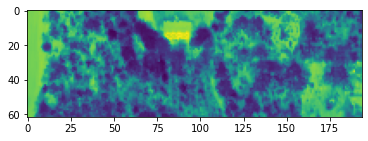

In [202]:
from matplotlib import pyplot as pyplot

plt.imshow(test[:,:,0])